In [1]:
import os
import cv2
from tqdm import tqdm
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import yaml
from collections import Counter

In [2]:
os.chdir('/home/gptrapletti/ds/satellite-multiclass-segm')

# <ins> DATA EXPLORATION ON THE ORIGINAL IMAGE AND MASK DATA

In [3]:
image_filepaths = sorted([os.path.join('data/images', filename) for filename in os.listdir(os.path.join('data/images'))])
mask_filepaths = sorted([os.path.join('data/masks', filename) for filename in os.listdir(os.path.join('data/masks'))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [17]:
# Check image sizes
sizes = []
for i in tqdm(range(len(image_filepaths))):
    image = cv2.imread(image_filepaths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_filepaths[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    size = (image.shape, mask.shape)
    sizes.append(size)
    
set(sizes)

100%|██████████| 400/400 [04:13<00:00,  1.58it/s]


{((4000, 6000, 3), (4000, 6000, 3))}

All the images have the same size.

In [11]:
category_colors = {
    "unlabeled": (0, 0, 0),
    "paved-area": (128, 64, 128),
    "dirt": (130, 76, 0),
    "grass": (0, 102, 0),
    "gravel": (112, 103, 87),
    "water": (28, 42, 168),
    "rocks": (48, 41, 30),
    "pool": (0, 50, 89),
    "vegetation": (107, 142, 35),
    "roof": (70, 70, 70),
    "wall": (102, 102, 156),
    "window": (254, 228, 12),
    "door": (254, 148, 12),
    "fence": (190, 153, 153),
    "fence-pole": (153, 153, 153),
    "person": (255, 22, 96),
    "dog": (102, 51, 0),
    "car": (9, 143, 150),
    "bicycle": (119, 11, 32),
    "tree": (51, 51, 0),
    "bald-tree": (190, 250, 190),
    "ar-marker": (112, 150, 146),
    "obstacle": (2, 135, 115),
    "conflicting": (255, 0, 0)
}

For each class, look for 3 random images showing that class, turn everything to black and then plot.

In [ ]:
random_idxs = list(range(len(mask_filepaths)))

category_examples = {}
for category in tqdm(category_colors):
    random.shuffle(random_idxs)
    example_idxs = []
    n = 0
    for i in random_idxs:
        n += 1
        mask = cv2.imread(mask_filepaths[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        has_color = np.any(np.all(mask == category_colors[category], axis=2)) # if mask == [128, 64, 128] across color channels
        # If it has at least a pixel with the object class color
        if has_color:
            example_idxs.append(i)
        if len(example_idxs) == 3: # examples found
            category_examples[category] = example_idxs           
            break
        elif i == random_idxs[-1]: # no examples found
            break

In [21]:
# # Saver dict
# with open('data/category_examples.json', 'w') as file:
#     json.dump(category_examples, file)

# Load dict
with open('data/category_examples.json', 'r') as file:
    category_example_idxs = json.load(file)

In [6]:
absent_categories = set(category_colors) - set(category_example_idxs)
print(f'Categories absent in the images are: {list(absent_categories)}')

Categories absent in the images are: ['conflicting']


In [83]:
# For each category, find 3 images with objects of that category, turn everything to background and save plots.
categories = sorted(list(category_example_idxs))

for category in tqdm(categories):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    for i, idx in enumerate(category_example_idxs[category]):
        # Load image
        image = cv2.imread(image_filepaths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (400, 300))
        # Load mask
        mask = cv2.imread(mask_filepaths[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (400, 300), interpolation=cv2.INTER_NEAREST)
        # Keep only category of interest in the mask
        filter = np.all(mask == category_colors[category], axis=2)
        filter = np.stack([filter]*3, axis=-1)
        # Filter image
        image_filtered = image * filter
        # Plot        
        axs[i].imshow(image_filtered)
        axs[i].axis('off')
        axs[i].set_title(category)
    
    fig.tight_layout()
    fig.savefig(f'plots/{category}.png')
    plt.close(fig)   

100%|██████████| 23/23 [00:48<00:00,  2.13s/it]


/tmp/ipykernel_5319/1253421455.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2, 4))


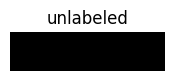

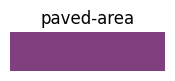

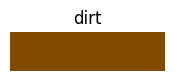

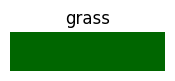

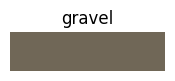

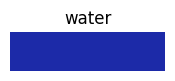

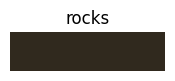

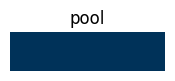

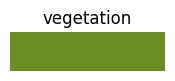

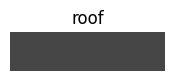

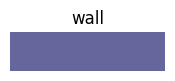

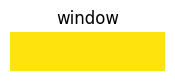

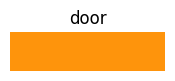

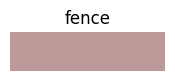

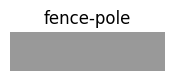

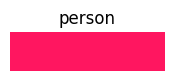

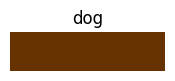

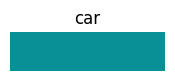

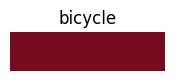

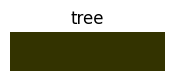

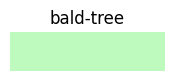

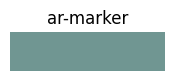

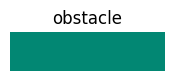

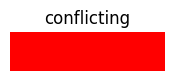

In [20]:
# Show category colors
for category in category_colors:
    color = category_colors[category]
    arr = np.stack(4*[color], axis=0)[np.newaxis, ...]
    plt.figure(figsize=(2, 4))
    plt.imshow(arr)
    plt.axis('off')
    plt.title(category)

In [ ]:
# Count total number of pixels for each category
# (Actually it's not the total numer of pixels because the
# images get resized and background is not counted).
pixel_counts = {key: 0 for key in category_colors}

for i in tqdm(range(len(mask_filepaths))):
    # Load mask
    mask = cv2.imread(mask_filepaths[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (400, 300), interpolation=cv2.INTER_NEAREST)
    # Init empty count dict for the mask
    mask_pixel_counts = {key: 0 for key in category_colors}
    # For each category count n pixels and add to mask dict
    for category in mask_pixel_counts:
        count = np.sum(np.all(mask == category_colors[category], axis=2))
        mask_pixel_counts[category] = count.item() # as int, not np.array
    # Add mask dict values to main dict
    for key in mask_pixel_counts:
        pixel_counts[key] += mask_pixel_counts[key]

100%|██████████| 400/400 [02:44<00:00,  2.43it/s]


In [22]:
# Save
# with open('data/category_pixel_counts.json', 'w') as file:
#     json.dump(pixel_counts, file)

# Load
with open('data/category_pixel_counts.json', 'r') as file:
    pixel_counts = json.load(file)

In [8]:
# Get percentage of pixels for each category on the total number of pixels
# belonging to some category.
n_tot_pixels = np.sum([pixel_counts[category] for category in pixel_counts])
pixel_percs = {category: np.round(pixel_counts[category]/n_tot_pixels, 4) for category in pixel_counts}

sorted(list(pixel_percs.items()), key=lambda x: -x[1])

[('paved-area', 0.3766),
 ('grass', 0.1994),
 ('roof', 0.0735),
 ('gravel', 0.0729),
 ('vegetation', 0.0709),
 ('obstacle', 0.0354),
 ('dirt', 0.0319),
 ('wall', 0.0268),
 ('water', 0.0221),
 ('tree', 0.0205),
 ('bald-tree', 0.0133),
 ('person', 0.0105),
 ('fence', 0.0096),
 ('car', 0.0078),
 ('rocks', 0.0072),
 ('pool', 0.0064),
 ('window', 0.0056),
 ('unlabeled', 0.0043),
 ('ar-marker', 0.0023),
 ('bicycle', 0.0022),
 ('fence-pole', 0.0005),
 ('door', 0.0003),
 ('dog', 0.0001),
 ('conflicting', 0.0)]

In [14]:
# Relabeling
regrouping = {
    'background': ['ar-marker', 'obstacle', 'car', 'unlabeled', 'bicycle', 'dog', 'conflicting', 'fence', 'pool', 'fence-pole'],
    'ground': ['paved-area', 'gravel', 'dirt', 'rocks'],
    'vegetation': ['grass', 'vegetation', 'tree', 'bald-tree'],
    'buildings': ['roof', 'wall', 'window', 'door'],
    'water': ['water'],
    'person' : ['person']
}

In [15]:
# New category percentages
new_pixel_percs = {}
for new_category in regrouping:
    new_category_pixel_count = []
    for category in regrouping[new_category]:
        new_category_pixel_count.append(pixel_counts[category])
    new_pixel_percs[new_category] = np.round(np.sum(new_category_pixel_count) / n_tot_pixels, 4)
    
sorted(list(new_pixel_percs.items()), key=lambda x:-x[1])       

[('ground', 0.4886),
 ('vegetation', 0.3041),
 ('buildings', 0.1062),
 ('background', 0.0686),
 ('water', 0.0221),
 ('person', 0.0105)]

In [16]:
# Original colors to map to the new categories
new_category_colors = {}

for new_category in regrouping:
    new_category_color_ls = []
    for category in regrouping[new_category]:
        new_category_color_ls.append(category_colors[category])
    new_category_colors[new_category] = new_category_color_ls
    
for item in new_category_colors.items():
    print(item)

('background', [(112, 150, 146), (2, 135, 115), (9, 143, 150), (0, 0, 0), (119, 11, 32), (102, 51, 0), (255, 0, 0), (190, 153, 153), (0, 50, 89), (153, 153, 153)])
('ground', [(128, 64, 128), (112, 103, 87), (130, 76, 0), (48, 41, 30)])
('vegetation', [(0, 102, 0), (107, 142, 35), (51, 51, 0), (190, 250, 190)])
('buildings', [(70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12)])
('water', [(28, 42, 168)])
('person', [(255, 22, 96)])


The "background" class name is later changed to "other" because it was not the proper background, which is absent since every pixel il labelled. 

# <ins> CHECK DATA AFTER PRE-PROCESSING

In [8]:
import yaml
with open('config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
    
cfg

{'images_dir': 'data/images',
 'masks_dir': 'data/masks',
 'n_random_patches_per_image': 50,
 'patch_size': 256,
 'patch_overlap': 0.5}

In [9]:
image_filepaths = sorted([os.path.join(cfg['images_dir'], filename) for filename in os.listdir(os.path.join(cfg['images_dir']))])
mask_filepaths = sorted([os.path.join(cfg['masks_dir'], filename) for filename in os.listdir(os.path.join(cfg['masks_dir']))])

len(image_filepaths), len(mask_filepaths)

(400, 400)

In [9]:
# Check image and mask sizes
sizes = []
for i in tqdm(range(len(image_filepaths))):
    image = cv2.imread(image_filepaths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_filepaths[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    size = (image.shape, mask.shape)
    sizes.append(size)
    
set(sizes)

100%|██████████| 400/400 [00:40<00:00,  9.76it/s]


{((2000, 3000, 3), (2000, 3000, 3))}

In [10]:
# Check class distribution as the number of masks having at least a pixel of that class
labels_ls = []
for i in tqdm(range(len(mask_filepaths))):
    mask = cv2.imread(mask_filepaths[i])[0]
    labels = np.unique(mask).tolist()
    for label in labels:
        labels_ls.append(label)
        
Counter(labels_ls)

# Counter({0: 395, 1: 386, 2: 325, 3: 276, 4: 156, 5: 66, 6: 32, 7: 1})

100%|██████████| 400/400 [00:05<00:00, 76.62it/s]


Counter({0: 395, 1: 386, 2: 325, 3: 276, 4: 156, 5: 66, 6: 32, 7: 1})

In [25]:
# New category percentages
# Relabeling
regrouping = {
    'background': ['ar-marker', 'obstacle', 'car', 'unlabeled', 'bicycle', 'dog', 'conflicting'],
    'ground': ['paved-area', 'gravel', 'dirt', 'rocks'],
    'vegetation': ['grass', 'vegetation', 'tree', 'bald-tree'],
    'buildings': ['roof', 'wall', 'window', 'door', 'fence', 'pool', 'fence-pole'],
    'water': ['water'],
    'person' : ['person']
}

n_tot_pixels = np.sum([pixel_counts[category] for category in pixel_counts])

new_pixel_percs = {}
for new_category in regrouping:
    new_category_pixel_count = []
    for category in regrouping[new_category]:
        new_category_pixel_count.append(pixel_counts[category])
    new_pixel_percs[new_category] = np.round(np.sum(new_category_pixel_count) / n_tot_pixels, 4)
    
sorted(list(new_pixel_percs.items()), key=lambda x:-x[1])

[('ground', 0.4886),
 ('vegetation', 0.3041),
 ('buildings', 0.1226),
 ('background', 0.0521),
 ('water', 0.0221),
 ('person', 0.0105)]

# <ins> COMPUTE NORMALIZATION PARAMETERS

In [ ]:
import torch

In [ ]:
norm_mean = torch.tensor(np.zeros(3)).to('cuda')

for i in tqdm(range(len(image_filepaths))):
    image = cv2.imread(image_filepaths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = torch.tensor(image).to('cuda')
    image = image / 255.0 # necessary to norm_mean to be [0, 1: float], as needed by A.Normalize
    image_mean = torch.mean(image, axis=(0, 1)) # image has shape: (width, height, channels)
    norm_mean = torch.add(norm_mean, image_mean)
    
norm_mean = norm_mean/len(image_filepaths)
norm_mean.item()

# [0.4456, 0.4436, 0.4018]

100%|██████████| 400/400 [00:26<00:00, 15.09it/s]


tensor([0.4456, 0.4436, 0.4018], device='cuda:0', dtype=torch.float64)

In [ ]:
norm_variance = torch.tensor(np.zeros(3)).to('cuda')

for i in tqdm(range(len(image_filepaths))):
    image = cv2.imread(image_filepaths[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = torch.tensor(image).to('cuda')
    image = image / 255.0
    for channel_idx in range(image.shape[-1]):
        channel = image[:, :, channel_idx]
        channel_variance = ((channel - norm_mean[channel_idx])**2).sum() / (channel.shape[0]*channel.shape[1])
        norm_variance[channel_idx] += channel_variance

norm_variance = norm_variance/len(image_filepaths)
norm_std = torch.sqrt(norm_variance)
norm_std.item()

# [0.2220, 0.2154, 0.2298]

100%|██████████| 400/400 [00:26<00:00, 15.20it/s]


tensor([0.2220, 0.2154, 0.2298], device='cuda:0', dtype=torch.float64)

# <ins> FIND GOOD SPLITS
Find how to split in train, val and test sets so that each set has more or less the original class frequencies.

## COUNT NUMBER OF PIXELS PER CATEGORY AND SAVE JSON

In [20]:
categories = [str(i) for i in range(0, 6)]

In [34]:
all_pixel_counts = {}
for i in tqdm(range(len(mask_filepaths))):
    filepath = mask_filepaths[i]
    filename = os.path.splitext(os.path.basename(filepath))[0]
    # Load mask
    mask = cv2.imread(filepath)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (1500, 1000), interpolation=cv2.INTER_NEAREST)
    mask = mask[..., 0]
    # Init empty count dict for the mask
    pixel_counts_i = {key: 0 for key in categories}
    # For each category count n pixels and add to mask dict
    for category in pixel_counts_i:
        count = np.sum(mask == int(category))
        pixel_counts_i[category] = count.item() # as int, not np.array
    # Add to dict
    all_pixel_counts[filename] = pixel_counts_i

100%|██████████| 400/400 [00:18<00:00, 22.15it/s]


In [35]:
# # Save
# with open('data/category_pixel_counts.json', 'w') as file:
#     json.dump(all_pixel_counts, file)

# Load
with open('data/category_pixel_counts.json', 'r') as file:
    all_pixel_counts = json.load(file)

## FIND BEST SPLIT

In [49]:
with open('data/good_splits.json', 'r') as file:
    splits = json.load(file)
    
len(splits)

19

In [52]:
splits[0]['train_diffs']

{'0': 0.004, '1': 0.0101, '2': 0.0029, '3': 0.003, '4': 0.0001, '5': 0.0}

In [54]:
# The best split is the one with the lowest differences
# all the diffs of a split are summed (separately for train, val, test)
# and the split with the lower results is considered the best
sums = []
for idx, split in enumerate(splits):
    train_diff_sum = sum(list(split['train_diffs'].values()))
    val_diff_sum = sum(list(split['val_diffs'].values()))
    test_diff_sum = sum(list(split['test_diffs'].values()))
    overall = train_diff_sum + val_diff_sum + test_diff_sum
    sums.append((idx, overall, (train_diff_sum, val_diff_sum, test_diff_sum)))
    
sorted(sums, key=lambda x: x[1])   

[(18, 0.0387, (0.0079, 0.0094, 0.0214)),
 (8, 0.0624, (0.0112, 0.009, 0.0422)),
 (17, 0.1023, (0.012299999999999998, 0.043899999999999995, 0.0461)),
 (13, 0.1086, (0.0255, 0.044300000000000006, 0.0388)),
 (1, 0.1285, (0.0294, 0.0475, 0.05160000000000001)),
 (14, 0.1402, (0.0184, 0.033100000000000004, 0.0887)),
 (15, 0.1469, (0.0208, 0.0437, 0.0824)),
 (6, 0.1472, (0.021199999999999997, 0.0698, 0.0562)),
 (0, 0.15400000000000003, (0.0201, 0.0675, 0.0664)),
 (9, 0.15560000000000002, (0.027200000000000002, 0.0499, 0.0785)),
 (2, 0.1613, (0.0218, 0.07119999999999999, 0.0683)),
 (16, 0.1615, (0.010199999999999999, 0.05430000000000001, 0.097)),
 (5, 0.1723, (0.03320000000000001, 0.044, 0.0951)),
 (12, 0.1835, (0.0167, 0.039900000000000005, 0.12689999999999999)),
 (7, 0.21889999999999998, (0.012199999999999999, 0.0793, 0.12739999999999999)),
 (11, 0.2216, (0.043199999999999995, 0.1182, 0.060200000000000004)),
 (3, 0.2297, (0.03320000000000001, 0.03, 0.16649999999999998)),
 (10,
  0.2755999999

In [55]:
splits[18]['train_diffs'], splits[18]['val_diffs'], splits[18]['test_diffs']

({'0': 0.0011, '1': 0.0017, '2': 0.0022, '3': 0.0029, '4': 0.0, '5': 0.0},
 {'0': 0.0013, '1': 0.0035, '2': 0.0013, '3': 0.0033, '4': 0.0, '5': 0.0},
 {'0': 0.0029, '1': 0.0018, '2': 0.0089, '3': 0.0077, '4': 0.0001, '5': 0.0})

In [56]:
# # Save split to file
# with open('data/split.json', 'w') as file:
#     split = splits[18]
#     del split['train_diffs'], split['val_diffs'], split['test_diffs']
#     json.dump(split, file)